##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Transformer model for language understanding

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/transformer">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/transformer.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial trains a <a href="https://arxiv.org/abs/1706.03762" class="external">transformer model</a> to translate a [Portuguese to English dataset](https://www.tensorflow.org/datasets/catalog/ted_hrlr_translate#ted_hrlr_translatept_to_en).

This is an advanced example that assumes knowledge of [text generation](https://www.tensorflow.org/text/tutorials/text_generation) and [attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention).

This tutorial demonstrates how to build a transformer model and most of its components *from scratch* using low-level TensorFlow and Keras functionalities. Some of this could be minimized if you took advantage of built-in APIs like `tf.keras.layers.MultiHeadAttention`.

The core idea behind a transformer model is *self-attention*—the ability to attend to different positions of the input sequence to compute a representation of that sequence. Transformer creates stacks of self-attention layers and is explained below in the sections *Scaled dot product attention* and *Multi-head attention*.

A transformer model handles variable-sized input using stacks of self-attention layers instead of [RNNs](https://www.tensorflow.org/text/tutorials/text_classification_rnn) or [CNNs](https://www.tensorflow.org/tutorials/images/cnn). This general architecture has a number of advantages:

* It makes no assumptions about the temporal/spatial relationships across the data. This is ideal for processing a set of objects (for example, [StarCraft units](https://deepmind.com/blog/alphastar-mastering-real-time-strategy-game-starcraft-ii/#block-8)).
* Layer outputs can be calculated in parallel, instead of a series like an RNN.
* Distant items can affect each other's output without passing through many RNN-steps, or convolution layers (see [Scene Memory Transformer](https://arxiv.org/pdf/1903.03878.pdf) for example).
* It can learn long-range dependencies. This is a challenge in many sequence tasks.

The downsides of this architecture are:

* For a time-series, the output for a time-step is calculated from the *entire history* instead of only the inputs and current hidden-state. This _may_ be less efficient.   
* If the input *does* have a  temporal/spatial relationship, like text, some positional encoding must be added or the model will effectively see a bag of words. 

After training the model in this notebook, you will be able to input a Portuguese sentence and return the English translation.

<img src="https://www.tensorflow.org/images/tutorials/transformer/attention_map_portuguese.png" width="800" alt="Attention heatmap">

## Setup

In [ ]:
!pip install tensorflow_datasets
!pip install -U 'tensorflow-text==2.8.*'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

# Import tf_text to load the ops used by the tokenizer saved model
import tensorflow_text  # pylint: disable=unused-import

In [ ]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings

## Download the Dataset

Use [TensorFlow datasets](https://www.tensorflow.org/datasets) to load the [Portuguese-English translation dataset](https://github.com/neulab/word-embeddings-for-nmt) from the [TED Talks Open Translation Project](https://www.ted.com/participate/translate).

This dataset contains approximately 50000 training examples, 1100 validation examples, and 2000 test examples.

In [ ]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
#Dataset load of portugese to english

train_examples, val_examples = examples['train'], examples['validation']

The `tf.data.Dataset` object returned by TensorFlow datasets yields pairs of text examples:

In [ ]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))

  print()

  for en in en_examples.numpy():
    print(en.decode('utf-8'))

e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


## Text tokenization & detokenization

You can't train a model directly on text. The text needs to be converted to some numeric representation first. Typically, you convert the text to sequences of token IDs, which are used as indices into an embedding.

One popular implementation is demonstrated in the [Subword tokenizer tutorial](https://www.tensorflow.org/text/guide/subwords_tokenizer) builds subword tokenizers (`text.BertTokenizer`) optimized for this dataset and exports them in a [saved_model](https://www.tensorflow.org/guide/saved_model).

Download and unzip and import the `saved_model`:

In [ ]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

'./ted_hrlr_translate_pt_en_converter.zip'

In [ ]:
tokenizers = tf.saved_model.load(model_name)

The `tf.saved_model` contains two text tokenizers, one for English and one for Portuguese. Both have the same methods:

In [ ]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

The `tokenize` method converts a batch of strings to a padded-batch of token IDs. This method splits punctuation, lowercases and unicode-normalizes the input before tokenizing. That standardization is not visible here because the input data is already standardized.

In [ ]:
for en in en_examples.numpy():
  print(en)
  print(en.decode('utf-8'))
  print()

b'and when you improve searchability , you actually take away the one advantage of print , which is serendipity .'
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .

b'but what if it were active ?'
but what if it were active ?

b"but they did n't test for curiosity ."
but they did n't test for curiosity .



In [ ]:
encoded = tokenizers.en.tokenize(en_examples)

for row in encoded.to_list():
  print(row)

# same words/subwords are given the same integral tokens, and I think tokens with similar meaning are closer , and the ones without the meaning are further apart
# d dimensional space

[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


The `detokenize` method attempts to convert these token IDs back to human readable text: 

In [ ]:
round_trip = tokenizers.en.detokenize(encoded)
print(round_trip)
for line in round_trip.numpy():
  print(line.decode('utf-8'))

tf.Tensor(
[b'and when you improve searchability , you actually take away the one advantage of print , which is serendipity .'
 b'but what if it were active ?'
 b"but they did n ' t test for curiosity ."], shape=(3,), dtype=string)
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


The lower level `lookup` method converts from token-IDs to token text:

In [ ]:
tokens = tokenizers.en.lookup(encoded)
# finding what 'en' / 'pt' value is assigned to which token
tokens

<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability',
  b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage',
  b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip',
  b'##ity', b'.', b'[END]']                                                 ,
 [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?',
  b'[END]']                                                           ,
 [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for',
  b'curiosity', b'.', b'[END]']                                          ]>

Here you can see the "subword" aspect of the tokenizers. The word "searchability" is decomposed into "search ##ability" and the word "serendipity" into "s ##ere ##nd ##ip ##ity"

Now take a minute to investigate the distribution of tokens per example in the dataset:

In [ ]:
lengths = []

for pt_examples, en_examples in train_examples.batch(1024):
  pt_tokens = tokenizers.en.tokenize(pt_examples)
  lengths.append(pt_tokens.row_lengths())

  en_tokens = tokenizers.en.tokenize(en_examples)
  lengths.append(en_tokens.row_lengths())
  print('.', end='', flush=True)

...................................................

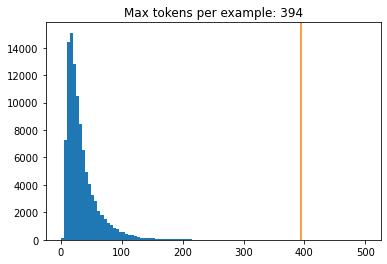

In [ ]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Max tokens per example: {max_length}');

In [ ]:
MAX_TOKENS = 128

## Setup input pipeline

To build an input pipeline suitable for training define some functions to transform the dataset.

Define a function to drop the examples longer than `MAX_TOKENS`:

In [ ]:
def filter_max_tokens(pt, en):
  num_tokens = tf.maximum(tf.shape(pt)[1],tf.shape(en)[1])
  return num_tokens < MAX_TOKENS

Define a function that tokenizes the batches of raw text:

In [ ]:
def tokenize_pairs(pt, en):
    pt = tokenizers.pt.tokenize(pt)
    # Convert from ragged to dense, padding with zeros.
    pt = pt.to_tensor()

    en = tokenizers.en.tokenize(en)
    # Convert from ragged to dense, padding with zeros.
    en = en.to_tensor()
    return pt, en

Here's a simple input pipeline that processes, shuffles and batches the data:

In [ ]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [ ]:
def make_batches(ds):
  """Makes batches for the dataset (ds) """
  return (
      ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
      .filter(filter_max_tokens)
      .prefetch(tf.data.AUTOTUNE))


train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

## Positional encoding

Attention layers see their input as a set of vectors, with no sequential order. This model also doesn't contain any recurrent or convolutional layers. Because of this a "positional encoding" is added to give the model some information about the relative position of the tokens in the sentence. 

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of tokens in a sentence. So after adding the positional encoding, tokens will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space.

The formula for calculating the positional encoding is as follows:

$$\Large{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [ ]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

  # There are n-dimensional positional encoding from library: positional_encoding

#0 (1, 2048, 512)
#1 (2048, 512)
#2 (2048, 256, 2)
#3 (2, 256, 2048)
#4 (512, 2048)


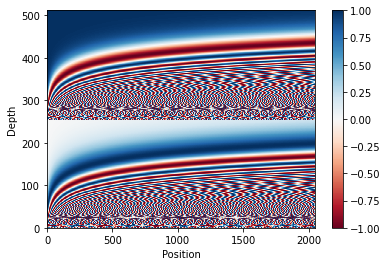

In [ ]:
# d_model: dimension of the model? 

n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print("#0", pos_encoding.shape)
pos_encoding = pos_encoding[0]
print("#1", pos_encoding.shape)

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
print("#2", pos_encoding.shape)
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
print("#3", pos_encoding.shape)
pos_encoding = tf.reshape(pos_encoding, (d, n))

print("#4", pos_encoding.shape)

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

## Masking

Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where pad value `0` is present: it outputs a `1` at those locations, and a `0` otherwise.

In [ ]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  # cast dtype to float32, and where there is zero put 1

  # add extra dimensions to add the padding
  # to the attention logits.
  # why only 2 dimensions in the padding mask for the attention logits
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [ ]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
print(create_padding_mask(x))
create_padding_mask(x).shape


tf.Tensor(
[[[[0. 0. 1. 1. 0.]]]


 [[[0. 0. 0. 1. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(3, 1, 1, 5), dtype=float32)


TensorShape([3, 1, 1, 5])

The look-ahead mask is used to mask the future tokens in a sequence. In other words, the mask indicates which entries should not be used.

This means that to predict the third token, only the first and second token will be used. Similarly to predict the fourth token, only the first, second and the third tokens will be used and so on.

In [ ]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0) # lower triangular part
  # mask = 1 - tf.linalg.band_part(tf.ones((size, size)), 0, -1) # upper triangular part
  # mask = 1 - tf.linalg.band_part(tf.ones((size, size)), 0, 0) # diagonal
  return mask  # (seq_len, seq_len)

# masking future tokens

In [ ]:
x = tf.random.uniform((1,3))
temp = create_look_ahead_mask(x.shape[1])
print(temp)
print(x)



tf.Tensor(
[[0. 1. 1.]
 [0. 0. 1.]
 [0. 0. 0.]], shape=(3, 3), dtype=float32)
tf.Tensor([[0.80083835 0.913458   0.6101421 ]], shape=(1, 3), dtype=float32)


Note: This mask indicates which entries to *not* because of the 1 - part,  attend to. However, the MultiHeadAttention layer in Keras that was added after the creation of this tutorial considers the inverted mask, where 1 is a token to be attended to and 0 should be ignored. If you are using `tf.keras.layers.MultiHeadAttention` instead of the MultiHeadAttention layer in this tutorial defined below, use the following commented out method to generate the mask. You will need to `pip install tensorflow-probability` and `import tensorflow_probability as tfp`.

In [ ]:
# def create_look_ahead_mask(size):
#     n = int(size * (size+1) / 2)
#     mask = tfp.math.fill_triangular(tf.ones((n,), dtype=tf.int32), upper=False)

## Scaled dot product attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

The attention function used by a transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k\left(\frac{QK^T}{\sqrt{d_k}}\right) V} $$

The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax.

For example, consider that `Q` and `K` have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of `dk`. So the *square root of `dk`* is used for scaling, so you get a consistent variance regardless of the value of `dk`. If the variance is too low the output may be too flat to optimize effectively. If the variance is too high the softmax may saturate at initialization making it difficult to learn.

The mask is multiplied with -1e9 (close to negative infinity). This is done because the mask is summed with the scaled matrix multiplication of Q and K and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  because every key corresponds to a specific value or set of values and hence the key should always correspond to something
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  [1,2,3](scaled_dot_product) + 4 (mask)= [5, 6, 7]

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

    depth: len of elements inside every single query, key or values 
    seq_len: multiple keys or values make up a sequence , and this shape describes the number of elements in that sequence.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  print(matmul_qk)

  # scale matmul_qk, scaling it down by the root of d(k)
  dk = tf.cast(tf.shape(k)[-1], tf.float32) # shape of the innermost values in the keys, 
  # its like the length of the keys (per key), if a key is a row vector
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)


  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9) # to make smaller values even smaller, so that softmax returns zero

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)
  # attention weights select the values in the output and allow a limited number of `values` to increase their magnitude
  # those values which increase their weights have greater attention weights attached to them

  return output, attention_weights

As the softmax normalization is done along the dimension for keys, the attention values decide the amount of importance given to the keys for each query.

The output represents the multiplication of the attention weights and the V (value) vector. This ensures that the tokens you want to focus on are kept as-is and the irrelevant tokens are flushed out.

In [ ]:
sample_array = np.array([[1,2], [3,4]])
print(sample_array)
print(tf.matmul(sample_array, sample_array, transpose_b=True))
print(tf.matmul(sample_array, sample_array))
print(tf.matmul(sample_array, sample_array, transpose_a=True))


[[1 2]
 [3 4]]
tf.Tensor(
[[ 5 11]
 [11 25]], shape=(2, 2), dtype=int64)
tf.Tensor(
[[ 7 10]
 [15 22]], shape=(2, 2), dtype=int64)
tf.Tensor(
[[10 14]
 [14 20]], shape=(2, 2), dtype=int64)


In [ ]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print('Attention weights are:')
  print(temp_attn)
  print('Output is:')
  print(temp_out)

In [ ]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

tf.Tensor([[  0. 100.   0.   0.]], shape=(1, 4), dtype=float32)
Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [ ]:
# This query aligns with a repeated key (third and fourth),
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

tf.Tensor([[  0.   0. 100. 100.]], shape=(1, 4), dtype=float32)
Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [ ]:
# This query aligns equally with the first and second key,
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

tf.Tensor([[100. 100.   0.   0.]], shape=(1, 4), dtype=float32)
Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


Pass all the queries together.

In [ ]:
temp_q = tf.constant([[0, 0, 10],
                      [0, 10, 0],
                      [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

tf.Tensor(
[[  0.   0. 100. 100.]
 [  0. 100.   0.   0.]
 [100. 100.   0.   0.]], shape=(3, 4), dtype=float32)
Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## Multi-head attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Multi-head attention consists of four parts:
*    Linear layers.
*    Scaled dot-product attention.
*    Final linear layer.

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers before the multi-head attention function.

In the diagram above `(K,Q,V)` are passed through sepearte linear (`Dense`) layers for each attention head. For simplicity/efficiency the code below implements this using a single dense layer with `num_heads` times as many outputs. The output is rearranged to a shape of `(batch, num_heads, ...)` before applying the attention function.

The `scaled_dot_product_attention` function defined above is applied in a single call, broadcasted for efficiency. An appropriate mask must be used in the attention step.  The attention output for each head is then concatenated (using `tf.transpose`, and `tf.reshape`) and put through a final `Dense` layer.

Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to jointly attend to information from different representation subspaces at different positions. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    # self init initialization
    self.num_heads = num_heads
    # num_heads: for the Multi Attention Head
    self.d_model = d_model
    # number of expected features in the encoder decoder inputs

    assert d_model % self.num_heads == 0 # dimension of the model should be
    # perfectly divisible by number of heads

    self.depth = d_model // self.num_heads
    # if the they are not perfectly divisible give the floor value of the quotient
    # depth is no. of elements inside one of the q, k, v

    self.wq = tf.keras.layers.Dense(d_model) # defining the shape of the Dense Layer
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3]) # not understood (perm argument)

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    # Adding another dimension for the num_heads
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
    print(output.shape, attention_weights.shape)
    return output, attention_weights

Create a `MultiHeadAttention` layer to try out. At each location in the sequence, `y`, the `MultiHeadAttention` runs all 8 attention heads across all other locations in the sequence, returning a new vector of the same length at each location.

In [ ]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

tf.Tensor(
[[[[-0.42010707 -2.1524563  -0.5773403  ... -1.9256173  -2.188413
    -1.8011913 ]
   [ 1.5518656   0.8826497   2.3731873  ... -0.22647919 -0.41261306
    -0.25681198]
   [ 3.8441415   0.9805741   2.0653908  ...  1.3866047   0.7149691
     1.8730581 ]
   ...
   [ 4.669474    2.749243    3.4740746  ...  3.5060987   2.7599075
     2.5742283 ]
   [ 0.8714472  -0.1739812   1.8277378  ...  1.837114    0.01385943
     0.463311  ]
   [ 2.7036805   1.1647546   0.532771   ...  2.3057454  -1.9437306
     1.559446  ]]

  [[-1.3114549   0.7988344   1.4972086  ...  0.6860504  -0.2531891
     1.0101118 ]
   [-0.18162237  2.1893208   2.0611312  ...  2.5664835   1.4084334
     1.9734718 ]
   [-0.96598756 -0.37385675  0.842045   ...  0.86270064  1.94384
     1.6795906 ]
   ...
   [-0.72883207  0.8251376   1.6081945  ...  0.24031223  0.47459716
     1.1586634 ]
   [-3.6118155  -1.1654088  -0.0461227  ...  0.46091023 -0.32923636
     0.08699661]
   [ 0.14165105  0.8323101   2.4764752  ...  2.2

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## Point wise feed forward network

Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [ ]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## Encoder and decoder

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

A transformer model follows the same general pattern as a standard [sequence to sequence with attention model](https://www.tensorflow.org/text/tutorials/nmt_with_attention.ipynb). 

* The input sentence is passed through `N` encoder layers that generates an output for each token in the sequence.
* The decoder attends to the encoder's output and its own input (self-attention) to predict the next word. 

### Encoder layer

Each encoder layer consists of sublayers:

1.   Multi-head attention (with padding mask)
2.    Point wise feed forward networks.

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis. There are N encoder layers in a transformer.

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, rate=0.1):
    # why star(*) is added in the arguments of __init__
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

In [ ]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

tf.Tensor(
[[[[ 2.126112    4.1928697   0.2709187  ...  4.2138395   0.90051156
     5.1016874 ]
   [-0.31816688  0.22965911 -1.630936   ...  1.4696915  -0.33000767
     1.1718421 ]
   [ 1.7236544   3.832501    0.8848362  ...  3.0705252   1.0378497
     2.4253366 ]
   ...
   [-0.21323703  1.4536767  -0.7906457  ...  1.8811148   0.1970693
     1.3519131 ]
   [ 0.28576788  1.8010095  -0.33073646 ...  3.055342   -0.04451552
     1.919656  ]
   [ 2.7336347   4.3205266   1.5074041  ...  4.481239    1.3985454
     4.25714   ]]

  [[ 0.3050299   2.7322032   0.4632577  ...  3.7186189   2.1992314
     2.0345776 ]
   [-1.7737321  -0.6102114  -2.6020288  ...  0.9968611  -0.34574708
    -2.1642172 ]
   [-1.1012409   1.7136456  -0.7736457  ...  3.2702043   1.7056227
    -0.97055304]
   ...
   [-2.3383622   1.5562545  -1.9057547  ...  0.4509568  -0.00130555
    -1.4113196 ]
   [-0.5662351   2.8481565  -0.02440297 ...  2.635946    2.6265187
    -0.32963383]
   [-0.820193    1.4582998  -1.331395   ... 

TensorShape([64, 43, 512])

### Decoder layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). V (value) and K (key) receive the *encoder output* as inputs. Q (query) receives the *output from the masked multi-head attention sublayer.*
3.   Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

There are a number of decoder layers in the model.

As Q receives the output from decoder's first attention block, and K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next token by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
    self.mha2 = MultiHeadAttention(d_model=d_model, num_heads=num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)

    # if they are Q, K, V , mask as the input of the MHA, why are enc_output being passed twice and
    #  output vector being passed as the value(i think so)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

In [ ]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output,
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

tf.Tensor(
[[[[-1.3759209  -1.4526384  -1.2653497  ... -0.17229177  0.16458775
     0.3433257 ]
   [-2.430407   -1.9843615  -3.4042819  ... -0.33400074 -1.1005147
    -0.35064757]
   [-0.54797447 -0.6358337  -2.531582   ...  0.21099466  0.2675896
     2.7779276 ]
   ...
   [-1.1696037  -0.41744995 -3.257672   ...  0.04050766  0.5449622
    -0.39222205]
   [ 0.79463696  1.1858726  -0.5454103  ...  2.7298346   1.6842805
     2.9650464 ]
   [-2.0856833  -1.7891331  -2.964764   ... -0.2764332  -0.9016463
     0.16082506]]

  [[ 0.6102235   2.4340878   2.0580533  ... -0.18688981  2.7593582
     2.7203734 ]
   [ 0.27098083  2.9128568   4.0872545  ...  2.5427325   3.3743699
     3.736529  ]
   [ 0.95609957  2.5156317   2.906542   ...  2.491284    1.7405696
     2.7752893 ]
   ...
   [ 0.9361321   0.81220984  0.5847725  ...  0.42812002  2.001699
     1.4430742 ]
   [-0.9035324   0.8268357   0.97231483 ... -0.31295738  0.6550545
     0.09068645]
   [-1.0963414  -0.77967125  0.8642966  ...  1.66

TensorShape([64, 50, 512])

### Encoder

The `Encoder` consists of:
1.   Input Embedding
2.   Positional Encoding
3.   N encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self,*, num_layers, d_model, num_heads, dff, input_vocab_size,
               rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    #using the embedding generator layer, creating an instance of embedding layer
    # MAX_TOKENS was defined earlier to be 128, represent mainly the seq_len
    self.pos_encoding = positional_encoding(MAX_TOKENS, self.d_model)
    # positional encoding , sinusoidal with different frequency, to give relative position information

    self.enc_layers = [
        EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate)
        for _ in range(num_layers)]

    # create a list of Encoder Layers, based on the num_layers

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    # gives seq_len, and x represents Q, K, and V

    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    # scaling based on multiplication of sqrt(d_model)
    x += self.pos_encoding[:, :seq_len, :]
    # adding pos_encoding to add relative location information in the x

    x = self.dropout(x, training=training)
    #droput at rate =0.1

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)

In [ ]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, input_vocab_size=8500)
# is the num_layers for encoder and decoder used for parallelizaition? 
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

tf.Tensor(
[[[[  8.819635    -3.9365747    1.9701483  ...   6.231417
     13.609092    17.155792  ]
   [ -2.2653844   -7.056013    -3.5913517  ...   4.2015867
     12.36145      8.335442  ]
   [ -4.915826    -1.9297454    2.3543777  ...  -2.559917
      4.1661777    5.5436587 ]
   ...
   [ -3.9860215    3.0884652   -2.4861553  ...   1.4879355
      1.8268213   -6.9826765 ]
   [  4.8267713    1.703619    -0.6280038  ...   6.6906023
      9.145727    -3.0733166 ]
   [  2.7401972    3.1730707   -2.796684   ...  -5.782711
     -3.8687234  -13.40083   ]]

  [[ -6.0049605   -4.328884   -12.708365   ...  -4.895749
    -14.601948    -1.7245227 ]
   [ -7.704686    -6.294946    -8.2078905  ...   1.9587327
     -9.069334     2.8856015 ]
   [ -6.79978     -9.790738    -0.5238908  ...  -2.6034799
     -0.9317424    4.599886  ]
   ...
   [  9.668826    -2.316121     4.4412932  ...  -4.052349
     -3.7975106    9.573719  ]
   [ 12.190599     3.4526398    6.370296   ...  -6.285299
     -1.7153196   -0

### Decoder

 The `Decoder` consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self,*, num_layers, d_model, num_heads, dff, target_vocab_size,
               rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    # do number of layers for encoder and decoder needs to same?

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    # embedding after tokenization, which leads to embedding in the output_dim space
    # vocab_size can be of order 10^4, but needs to indexed in d_model dimensions
    self.pos_encoding = positional_encoding(MAX_TOKENS, d_model)

    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate)
        for _ in range(num_layers)]
    #create num_layers number of decoder layers in the form of a list  
    self.dropout = tf.keras.layers.Dropout(rate)


  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1] 
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    # output vocab_size embedding
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    # scaling the embedding of the vocab with sqrt(x)

    x += self.pos_encoding[:, :seq_len, :]
    # giving sinusoidal positional encoding to the input vocab, by adding this
    # value to the input vocab 

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      # final output logits and attention values from block 1 and block 2

      attention_weights[f'decoder_layer{i+1}_block1'] = block1
      # i+1 because python iterates from 0 will the range of the int specified
      attention_weights[f'decoder_layer{i+1}_block2'] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [ ]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, target_vocab_size=8000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)
# here the values in axis = 1 : 26 whereas in encoder it was specified as 62

output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)

print(len(attn))
output.shape, attn['decoder_layer2_block2'].shape


tf.Tensor(
[[[[ -4.022006     2.141916     3.2370927  ...  -3.8573365
      3.1235      -0.6577167 ]
   [ -8.054807    -2.774547     0.1378259  ...  -3.4855945
      1.4063764    2.2389934 ]
   [ -5.0767865    4.659066     8.959474   ... -11.683198
     -2.373031    -9.760758  ]
   ...
   [  4.429589    -2.586067     5.279259   ...   0.5947123
     17.84034     -1.6590209 ]
   [  8.503693     7.7395105    8.410126   ...   5.595749
     26.6509       5.9674444 ]
   [  0.03309891   1.0300817   11.11753    ...   2.018362
     17.360304    -0.15835574]]

  [[  1.4119912   -3.38917     -4.409175   ...  -0.4653451
     -2.4442942   -0.75388837]
   [ -4.533934    -3.0346289   -1.865823   ...   5.0278225
      1.7264775  -10.21327   ]
   [  3.0717094    3.7506185   -1.4998564  ...   7.771309
     -1.1781542   -7.6928883 ]
   ...
   [  2.0628192   11.109846     3.680744   ...   6.0689735
      7.0577536    5.225267  ]
   [ -5.411074    -0.11569178  -4.6470385  ...  -2.4694626
      7.4175353   

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## Create the transformer model

A transformer consists of the encoder, decoder, and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self,*, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           input_vocab_size=input_vocab_size, rate=rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           target_vocab_size=target_vocab_size, rate=rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs, training):
    """used for training the transformers"""
    # Keras models prefer if you pass all your inputs in the first argument
    inp, tar = inputs
    # passing input with input vocabulary and output vocabulary
    padding_mask, look_ahead_mask = self.create_masks(inp, tar)
    # padding masks used for the Encoder (Encoder Layers)
    # padding and look ahead masks used for Decoder (Decoder Layers)

    enc_output = self.encoder(inp, training, padding_mask)  # (batch_size, inp_seq_len, d_model)
    # attn_output after the process of concatenation from all the layers and heads is passed as enc_output
    # final attention weights are not passed in the Transformer here

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, padding_mask)
    #decoder attn output through taking encoder output, where the attn_weights from self-attention block (block1)
    # and other attention block (block 2) is passed into a dict (attention_weights)
    # training: mentions whether the model is training at the moment

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    #final layer is a dense layer of target vocab_size
    
    return final_output, attention_weights

  def create_masks(self, inp, tar):
    # Encoder padding mask (Used in the 2nd attention block in the decoder too.)
    padding_mask = create_padding_mask(inp)
    # creates padding where on where the value are zero or the when the vector is short in length

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    # using triangular mask with 1s on the upper right corner
    dec_target_padding_mask = create_padding_mask(tar)
    look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    # combining both the masks

    return padding_mask, look_ahead_mask

In [ ]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048,
    input_vocab_size=8500, target_vocab_size=8000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200) 
#target seq_len 2 less than the input seq_len

fn_out, _ = sample_transformer([temp_input, temp_target], training=False)
# fn_out: final output passed through encoder and then decoder through a dense layer of target vocab size
# _ here: attention weights coming from the Decoder of the transformers

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

tf.Tensor(
[[[[ -3.9163585    6.973575     1.7124835  ...   2.5731075
     -1.4299943    4.2267313 ]
   [  7.7493906   15.011031     7.7501473  ...   4.212664
      6.153917     1.6184202 ]
   [ -3.9439995    9.4984255    5.8377223  ...   4.621908
     -0.10959599   5.8364615 ]
   ...
   [ -0.25918984   0.6788842    1.6350954  ...   1.523072
     -6.9636307   -9.955442  ]
   [ -2.4483821   -3.390713     2.5393276  ...  -8.013113
     -5.849854    -7.74917   ]
   [ -0.42048055  -1.4516156    3.5653012  ...  -7.8365307
     -9.175553    -8.844566  ]]

  [[ -4.354834     2.9119182    9.883269   ...   7.2777176
      9.400575     9.262568  ]
   [ -1.7926446    4.7229037    7.8856483  ...   4.176486
     11.181193     4.023801  ]
   [ -2.3037915   -0.96408343  -0.69956344 ...  -1.7747312
      8.84455      8.106197  ]
   ...
   [ 11.83117     10.087168     8.368823   ...   1.3704247
      1.8007073    5.650678  ]
   [ -4.549067    -2.98293     -2.023529   ...  -2.618339
     -1.6096522   -4

TensorShape([64, 36, 8000])

## Set hyperparameters

To keep this example small and relatively fast, the values for `num_layers, d_model, dff` have been reduced. 

The base model described in the [paper](https://arxiv.org/abs/1706.03762) used: `num_layers=6, d_model=512, dff=2048`.

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

## Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}$$


In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    # as mentioned in the above equation and in the paper

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)
# d_model : expected features by encoder and decoder model 
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

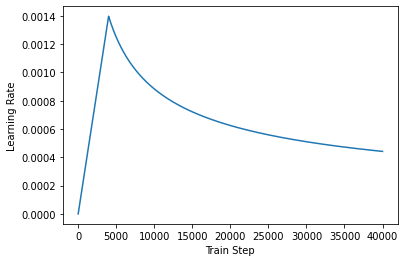

In [ ]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

## Loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [ ]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  # mask: {1 if value is 0, otherwise 0}
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)

  loss_ *= mask
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))
  # bool : 1, if pred == real, else 0 

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  #bool value 1, when real == 0, else 0
  accuracies = tf.math.logical_and(mask, accuracies)
  # if both are 1 then output 1, otherwise that particular 
  # index needs not to be considered and won't contribute 
  # to accuracy

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  # casting the values to float32
  mask = tf.cast(mask, dtype=tf.float32)

  #sum all the values in the n_dimensional matrix (mask, accuracies)
  # since valid_masks represent total values that need to be considered
  # reduce_sum(accuracies) need to be divided by the reduce_sum(mask)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

# computes weighted mean of the train_accuracy and tran_loss

## Training and checkpointing

In [ ]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    rate=dropout_rate)

Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every `n` epochs.

In [ ]:
checkpoint_path = './checkpoints/train'

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

Latest checkpoint restored!!


The target is divided into tar_inp and tar_real. tar_inp is passed as an input to the decoder. `tar_real` is that same input shifted by 1: At each location in `tar_input`, `tar_real` contains the  next token that should be predicted.

For example, `sentence = 'SOS A lion in the jungle is sleeping EOS'` becomes:

* `tar_inp =  'SOS A lion in the jungle is sleeping'`
* `tar_real = 'A lion in the jungle is sleeping EOS'`

A transformer is an auto-regressive model: it makes predictions one part at a time, and uses its output so far to decide what to do next.

During training this example uses teacher-forcing (like in the [text generation tutorial](https://www.tensorflow.org/text/tutorials/text_generation)). Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step.

As the model predicts each token, *self-attention* allows it to look at the previous tokens in the input sequence to better predict the next token.

To prevent the model from peeking at the expected output the model uses a look-ahead mask.

In [ ]:
EPOCHS = 20

In [ ]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

# For making model.fit() train_step function which is already given here
@tf.function(input_signature=train_step_signature)
# tf.function: creates a graph which gives importance to tensorflow operations and leads to faster computation with less runtime
# This allows if the function is run for the first time to create tf.variables, and mainly created to reduce the amount of retracing in the code
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  # the left chunk of the target is given to the model as input which contains all the values except the last value, and will be n-1 length if total_len = n
  tar_real = tar[:, 1:]
  # this tar_real would contain that last nth value as that value needs to be predicted by the decoder model. 
  # the values are right shifted for the truth values

  with tf.GradientTape() as tape:
    # for automatic differentiation 
    predictions, _ = transformer([inp, tar_inp],
                                 training = True)
    # now the predictions from the decoder model will come as soon as the encoder gives output for a specific token, now here lookahead mask is used so that the 
    # transformer model doesn't see the future truth values from the dataset. 

    loss = loss_function(tar_real, predictions)
    # loss function as defined earlier, gives a CategoricalCrossEntropyLoss(real, pred) multiplied by mask. On which the model optimises and updates the model.

  gradients = tape.gradient(loss, transformer.trainable_variables)
  # gradient of the loss function is calculated for the network to bring the the trainable variables to the optimal variable
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  # applies the gradients and updates the trainable variables, last_value + updated value


  train_loss(loss) # mean loss is calculated from a list of losses
  train_accuracy(accuracy_function(tar_real, predictions)) # mean accuracy is calculated from a list of accuracies

# Part 3: TransformerModel 
1. has model.fit() functionality
2. has model.compile() with custom loss functions and metrics

In [ ]:
class TransformerModel(tf.keras.Model):
  def __init__(self,*, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, training, rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           input_vocab_size=input_vocab_size, rate=rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           target_vocab_size=target_vocab_size, rate=rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    self.training = training



  def compile(self, optimizer, loss, metrics):
    super(TransformerModel, self).compile()
    self.optimizer = optimizer
    self.loss = loss

  def train_step(inp, tar):
    #explained before in the previous cell
    inp = tf.keras.layers.Input(shape=(None,))
    tar = tf.keras.layers.Input(shape=(None,))
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    with tf.GradientTape() as tape:
      predictions, _ = transformer([inp, tar_inp],
                                  training = True)
      loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    # defined above as mean of logicalAND(mask, SparseCategoricalEntropyLoss(y_true, y_pred))
    train_accuracy(accuracy_function(tar_real, predictions))
    # defined above

  def call(self, inp, tar):
    input = tf.keras.layers.Input(shape=(None,))
    target = tf.keras.layers.Input(shape=(None,))
    return tf.keras.models.Model(inputs = [input, target], outputs = self.transformer())
  
  def transformer(self, inputs):
    """used for training the transformers"""
    # Keras models prefer if you pass all your inputs in the first argument
    training = self.training
    inp, tar = inputs
    inp = tf.keras.layers.Input(shape=(None,))
    tar = tf.keras.layers.Input(shape=(None,))
    # passing input with input vocabulary and output vocabulary
    padding_mask, look_ahead_mask = self.create_masks(inp, tar)
    # padding masks used for the Encoder (Encoder Layers)
    # padding and look ahead masks used for Decoder (Decoder Layers)

    enc_output = self.encoder(inp, training, padding_mask)  # (batch_size, inp_seq_len, d_model)
    # attn_output after the process of concatenation from all the layers and heads is passed as enc_output
    # final attention weights are not passed in the Transformer here

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, padding_mask)
    # decoder utilises num_layers of decoder_layers each having subspace to compute the final_output
    #decoder attn output through taking encoder output, where the attn_weights from self-attention block (block1)
    # and other attention block (block 2) is passed into a dict (attention_weights)
    # training: mentions whether the model is training at the moment

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    #final layer is a dense layer of target vocab_size
    
    return final_output, attention_weights

  def create_masks(self, inp, tar):
    # Encoder padding mask (Used in the 2nd attention block in the decoder too.)
    padding_mask = create_padding_mask(inp)
    # creates padding where on where the value are zero or the when the vector is short in length

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    # using triangular mask with 1s on the upper right corner
    dec_target_padding_mask = create_padding_mask(tar)
    look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    # combining both the masks

    return padding_mask, look_ahead_mask

  def generator(dataset):
    while True:
      for pt_batch, en_batch in dataset:
        yield ( [pt_batch , en_batch[:, :-1] ] , en_batch[:, 1:] )
  

In [ ]:
model = TransformerModel(num_layers=num_layers,
                         d_model=d_model,
                         num_heads=num_heads,
                         dff=dff,
                         input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
                         target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
                         training = True,
                         rate=dropout_rate)

In [ ]:
input = tf.keras.layers.Input(shape=(None,))
target = tf.keras.layers.Input(shape=(None,))

x, _ = transformer([input, target],training = True)
model = tf.keras.models.Model(inputs=[input, target], outputs=x)

Tensor("transformer_1/encoder_2/encoder_layer_5/multi_head_attention_16/MatMul:0", shape=(None, 8, None, None), dtype=float32)
(None, None, 128) (None, 8, None, None)
Tensor("transformer_1/encoder_2/encoder_layer_6/multi_head_attention_17/MatMul:0", shape=(None, 8, None, None), dtype=float32)
(None, None, 128) (None, 8, None, None)
Tensor("transformer_1/encoder_2/encoder_layer_7/multi_head_attention_18/MatMul:0", shape=(None, 8, None, None), dtype=float32)
(None, None, 128) (None, 8, None, None)
Tensor("transformer_1/encoder_2/encoder_layer_8/multi_head_attention_19/MatMul:0", shape=(None, 8, None, None), dtype=float32)
(None, None, 128) (None, 8, None, None)
Tensor("transformer_1/decoder_2/decoder_layer_5/multi_head_attention_20/MatMul:0", shape=(None, 8, None, None), dtype=float32)
(None, None, 128) (None, 8, None, None)
Tensor("transformer_1/decoder_2/decoder_layer_5/multi_head_attention_21/MatMul:0", shape=(None, 8, None, None), dtype=float32)
(None, None, 128) (None, 8, None, None

In [ ]:
metrics = [loss_object, loss_function, tf.keras.metrics.SparseCategoricalAccuracy()]

model.compile(optimizer=optimizer, loss = loss_object, metrics = metrics)

In [ ]:
for (batch, (_)) in enumerate(train_batches):
  # for finding the batch size in this PrefetchDataset, as the .batch doesn't give the batch size value
  steps = batch
#using the function generator
history = model.fit(x = generator(train_batches), epochs=20, steps_per_epoch = steps)

Epoch 1/20
Tensor("model_1/transformer_1/encoder_2/encoder_layer_5/multi_head_attention_16/MatMul:0", shape=(None, 8, None, None), dtype=float32)
(None, None, 128) (None, 8, None, None)
Tensor("model_1/transformer_1/encoder_2/encoder_layer_6/multi_head_attention_17/MatMul:0", shape=(None, 8, None, None), dtype=float32)
(None, None, 128) (None, 8, None, None)
Tensor("model_1/transformer_1/encoder_2/encoder_layer_7/multi_head_attention_18/MatMul:0", shape=(None, 8, None, None), dtype=float32)
(None, None, 128) (None, 8, None, None)
Tensor("model_1/transformer_1/encoder_2/encoder_layer_8/multi_head_attention_19/MatMul:0", shape=(None, 8, None, None), dtype=float32)
(None, None, 128) (None, 8, None, None)
Tensor("model_1/transformer_1/decoder_2/decoder_layer_5/multi_head_attention_20/MatMul:0", shape=(None, 8, None, None), dtype=float32)
(None, None, 128) (None, 8, None, None)
Tensor("model_1/transformer_1/decoder_2/decoder_layer_5/multi_head_attention_21/MatMul:0", shape=(None, 8, None, N

## Custom Training Loop

Portuguese is used as the input language and English is the target language.

In [ ]:
EPOCHS  = 30
for epoch in range(EPOCHS):
  #iterating over all the range of EPOCHS
  start = time.time()
  # for timing the function loop, could have used tqdm also

  train_loss.reset_states()
  # reseting states is necessary for these metrics otherwise values get compounded
  train_accuracy.reset_states()

  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_batches):
    #iterating over the Prefetchdataset of train_batches
    train_step(inp, tar)
    #passing these values to the train_step function , and this function is what makes it easier to implement model.fit()

    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
      #metrics after each epoch

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    # checkpoing value saving for the tf.variable and other parameters
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
  # printing metrics after all the epochs

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

### Run inference

The following steps are used for inference:

* Encode the input sentence using the Portuguese tokenizer (`tokenizers.pt`). This is the encoder input.
* The decoder input is initialized to the `[START]` token.
* Calculate the padding masks and the look ahead masks.
* The `decoder` then outputs the predictions by looking at the `encoder output` and its own output (self-attention).
* Concatenate the predicted token to the decoder input and pass it to the decoder.
* In this approach, the decoder predicts the next token based on the previous tokens it predicted.

Note: The model is optimized for _efficient training_ and makes a next-token prediction for each token in the output simultaneously. This is redundant during inference, and only the last prediction is used.  This model can be made more efficient for inference if you only calculate the last prediction when running in inference mode (`training=False`).

In [ ]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # input sentence is portuguese, hence adding the start and end token
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # As the output language is english, initialize the output with the
    # english start token.
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a python list) so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions, _ = self.transformer([encoder_input, output], training=False)

      # select the last token from the seq_len dimension
      predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

      predicted_id = tf.argmax(predictions, axis=-1)

      # concatentate the predicted_id to the output which is given to the decoder
      # as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # output.shape (1, tokens)
    text = tokenizers.en.detokenize(output)[0]  # shape: ()

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop. So recalculate them outside
    # the loop.
    _, attention_weights = self.transformer([encoder_input, output[:,:-1]], training=False)

    return text, tokens, attention_weights

Note: This function uses an unrolled loop, not a dynamic loop. It generates `MAX_TOKENS` on every call. Refer to [NMT with attention](nmt_with_attention.ipynb) for an example implementation with a dynamic loop, which can be much more efficient.

Create an instance of this `Translator` class, and try it out a few times:

In [ ]:
translator = Translator(tokenizers, transformer)

In [ ]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [ ]:
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

In [ ]:
sentence = 'os meus vizinhos ouviram sobre esta ideia.'
ground_truth = 'and my neighboring homes heard about this idea .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

In [ ]:
sentence = 'vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.'
ground_truth = "so i'll just share with you some stories very quickly of some magical things that have happened."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

## Attention plots

The `Translator` class returns a dictionary of attention maps you can use to visualize the internal working of the model:

In [ ]:
sentence = 'este é o primeiro livro que eu fiz.'
ground_truth = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

In [ ]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The plot is of the attention when a token was generated.
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [ ]:
head = 0
# shape: (batch=1, num_heads, seq_len_q, seq_len_k)
attention_heads = tf.squeeze(
  attention_weights['decoder_layer4_block2'], 0)
attention = attention_heads[head]
attention.shape

In [ ]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens

In [ ]:
translated_tokens

In [ ]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [ ]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]
  in_tokens

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

In [ ]:
plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])

The model does okay on unfamiliar words. Neither "triceratops" or "encyclopedia" are in the input dataset and the model almost learns to transliterate them, even without a shared vocabulary:

In [ ]:
sentence = 'Eu li sobre triceratops na enciclopédia.'
ground_truth = 'I read about triceratops in the encyclopedia.'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])

## Export

That inference model is working, so next you'll export it as a `tf.saved_model`.

To do that, wrap it in yet another `tf.Module` sub-class, this time with a `tf.function` on the `__call__` method:

In [ ]:
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result,
     tokens,
     attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)

    return result

In the above `tf.function` only the output sentence is returned. Thanks to the [non-strict execution](https://tensorflow.org/guide/intro_to_graphs) in `tf.function` any unnecessary values are never computed.

In [ ]:
translator = ExportTranslator(translator)

Since the model is decoding the predictions using `tf.argmax` the predictions are deterministic. The original model and one reloaded from its `SavedModel` should give identical predictions:

In [ ]:
translator('este é o primeiro livro que eu fiz.').numpy()

In [ ]:
tf.saved_model.save(translator, export_dir='translator')

In [ ]:
reloaded = tf.saved_model.load('translator')

In [ ]:
reloaded('este é o primeiro livro que eu fiz.').numpy()

## Summary

In this tutorial you learned about:

* positional encoding
* multi-head attention
* the importance of masking 
* and how to put it all together to build a transformer.

This implementation tried to stay close to the implementation of the 
[original paper](https://arxiv.org/abs/1706.03762). If you want to practice there are many things you could try with it. For example: 

* Using a different dataset to train the transformer.
* Create the "Base Transformer" or "Transformer XL" configurations from the original paper by changing the hyperparameters.
* Use the layers defined here to create an implementation of [BERT](https://arxiv.org/abs/1810.04805).
* Implement beam search to get better predictions.